# Factorization Machine Deep Dive

Factorization machine (FM) is one of the representative algorithms that are used for building hybrid recommenders model. The algorithm is powerful in terms of capturing the effects of not just the input features but also their interactions. The algorithm provides better generalization capability and expressiveness compared to other classic algorithms such as SVMs. 

This notebook presents a deep dive into the Factorization Machine algorithm, and demonstrates some best practices of using the contemporary FM implementations like [`xlearn`](https://github.com/aksnzhy/xlearn) for dealing with tasks like click-through rate prediction.

## 1 Factorization Machine

### 1.1 Factorization Machine

FM is an algorithm that uses factorization in prediction tasks with data set of high sparsity. The algorithm was original proposed in [\[1\]](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf). Traditionally, the algorithms such as SVM do not perform well in dealing with highly sparse data that is usually seen in many contemporary problems, e.g., click-through rate prediction, recommendation, etc. FM handles the problem by modeling not just first-order linear components for predicting the label, but also the cross-product of the feature variables in order to capture more generalized correlation between variables and label. 

In certain occasions, the data that appears in recommendation problems, such as user, item, and feature vectors, can be encoded into a one-hot representation. Under this arrangement, classical algorithms like linear regression and SVM may suffer from the following problems:
1. The feature vectors are highly sparse, and thus it makes it hard to optimize the parameters to fit the model efficienly
2. Cross-product of features will be sparse as well, and this in turn, reduces the expressiveness of a model if it is designed to capture the high-order interactions between features

<img src="https://recodatasets.z20.web.core.windows.net/images/fm_data.png?sanitize=true">

The FM algorithm is designed to tackle the above two problems by factorizing latent vectors that model the low- and high-order components. The general idea of a FM model is expressed in the following equation:

$$\hat{y}(\textbf{x})=w_{0}+\sum^{n}_{i=1}w_{i}x_{i}+\sum^{n}_{i=1}\sum^{n}_{j=i+1}<\textbf{v}_{i}, \textbf{v}_{j}>x_{i}x_{j}$$

where $\hat{y}$ and $\textbf{x}$ are the target to predict and input feature vectors, respectively. $w_{i}$ is the model parameters for the first-order component. $<\textbf{v}_{i}, \textbf{v}_{j}>$ is the dot product of two latent factors for the second-order interaction of feature variables, and it is defined as  

$$<\textbf{v}_{i}, \textbf{v}_{j}>=\sum^{k}_{f=1}v_{i,f}\cdot v_{j,f}$$

Compared to using fixed parameter for the high-order interaction components, using the factorized vectors increase generalization as well as expressiveness of the model. In addition to this, the computation complexity of the equation (above) is $O(kn)$ where $k$ and $n$ are the dimensionalities of the factorization vector and input feature vector, respectively (see [the paper](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf) for detailed discussion). In practice, usually a two-way FM model is used, i.e., only the second-order feature interactions are considered to favor computational efficiency.

### 1.2 Field-Aware Factorization Machine

Field-aware factorization machine (FFM) is an extension to FM. It was originally introduced in [\[2\]](https://www.csie.ntu.edu.tw/~cjlin/papers/ffm.pdf). The advantage of FFM over FM is that, it uses different factorized latent factors for different groups of features. The "group" is called "field" in the context of FFM. Putting features into fields resolves the issue that the latent factors shared by features that intuitively represent different categories of information may not well generalize the correlation. 

Different from the formula for the 2-order cross product as can be seen above in the FM equation, in the FFM settings, the equation changes to 

$$\theta_{\text{FFM}}(\textbf{w}\textbf{x})=\sum^{n}_{j1=1}\sum^{n}_{j2=j1+1}<\textbf{v}_{j1,f2}, \textbf{v}_{j2,f1}>x_{j1}x_{j2}$$

where $f_1$ and $f_2$ are the fields of $j_1$ and $j_2$, respectively.

Compared to FM, the computational complexity increases to $O(n^2k)$. However, since the latent factors in FFM only need to learn the effect within the field, so the $k$ values in FFM is usually much smaller than that in FM.

## 2 xlearn

Setups for using `xlearn`.

1. `xlearn` is implemented in C++ and has Python bindings, so it can be directly installed as a Python package from PyPI. The installation of `xlearn` is enabled in the [Recommenders repo environment setup script](../../tools/generate_conda_file.py). One can follow the general setup steps to install the environment as required, in which `xlearn` is installed as well.
2. NOTE `xlearn` may require some base libraries installed as prerequisites in the system, e.g., `cmake`.

After a succesful creation of the environment, one can load the packages to run `xlearn` in a Jupyter notebook or Python script.

In [23]:
import sys
sys.path.append("../../")
import os
import papermill as pm
import scrapbook as sb
from tempfile import TemporaryDirectory
import xlearn as xl
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib notebook
from matplotlib import pyplot as plt

from reco_utils.common.constants import SEED
from reco_utils.common.timer import Timer
from reco_utils.recommender.deeprec.deeprec_utils import (
    download_deeprec_resources, prepare_hparams
)
from reco_utils.recommender.deeprec.models.xDeepFM import XDeepFMModel
from reco_utils.recommender.deeprec.io.iterator import FFMTextIterator
from reco_utils.tuning.parameter_sweep import generate_param_grid
from reco_utils.dataset.pandas_df_utils import LibffmConverter

print("System version: {}".format(sys.version))
print("Xlearn version: {}".format(xl.__version__))

System version: 3.6.11 | packaged by conda-forge | (default, Nov 27 2020, 18:51:43) 
[GCC Clang 11.0.0]
Xlearn version: 0.4.0


In the FM model building, data is usually represented in the libsvm data format. That is, `label feat1:val1 feat2:val2 ...`, where `label` is the target to predict, and `val` is the value to each feature `feat`.

FFM algorithm requires data to be represented in the libffm format, where each vector is split into several fields with categorical/numerical features inside. That is, `label field1:feat1:val1 field2:feat2:val2 ...`.

In the Microsoft/Recommenders utility functions, [a libffm converter](../../reco_utils/dataset/pandas_df_utils.py) is provided to achieve the transformation from a tabular feature vectors to the corresponding libffm representation. For example, the following shows how to transform the format of a synthesized data by using the module of `LibffmConverter`. Ths synthesized data includes categorical and numerical features, which the converter automatically indexed.

In [6]:
df_feature_original = pd.DataFrame({
    'rating': [1, 0, 0, 1, 1],
    'field1': ['xxx1', 'xxx2', 'xxx4', 'xxx4', 'xxx4'],
    'field2': [3, 4, 5, 6, 7],
    'field3': [1.0, 2.0, 3.0, 4.0, 5.0],
    'field4': ['1', '2', '3', '4', '5']
})

converter = LibffmConverter().fit(df_feature_original, col_rating='rating')
df_out = converter.transform(df_feature_original)
df_out

,rating,field1,field2,field3,field4
0,1,1:1:1,2:4:3,3:5:1.0,4:6:1
1,0,1:2:1,2:4:4,3:5:2.0,4:7:1
2,0,1:3:1,2:4:5,3:5:3.0,4:8:1
3,1,1:3:1,2:4:6,3:5:4.0,4:9:1
4,1,1:3:1,2:4:7,3:5:5.0,4:10:1


In [7]:
print('There are in total {0} fields and {1} features.'.format(converter.field_count, converter.feature_count))

There are in total 4 fields and 10 features.


To illustrate the use of `xlearn`, the following example uses the [Criteo data set](https://labs.criteo.com/category/dataset/), which has already been processed in the libffm format, for building and evaluating a FFM model built by using `xlearn`. Sometimes, it is important to know the total numbers of fields and features. When building a FFM model, `xlearn` can count these numbers automatically.

In [24]:
# Parameters
YAML_FILE_NAME = "xDeepFM.yaml"
TRAIN_FILE_NAME = "cretio_tiny_train"
VALID_FILE_NAME = "cretio_tiny_valid"
TEST_FILE_NAME = "cretio_tiny_test"
MODEL_FILE_NAME = "model.out"
OUTPUT_FILE_NAME = "output.txt"

LEARNING_RATE = 0.2
LAMBDA = 0.002
# The metrics for binary classification options are "acc", "prec", "f1" and "auc"
# for regression, options are "rmse", "mae", "mape"
METRIC = "auc" 
EPOCH = 10
OPT_METHOD = "sgd" # options are "sgd", "adagrad" and "ftrl"

In [25]:
tmpdir = TemporaryDirectory()

data_path = tmpdir.name
yaml_file = os.path.join(data_path, YAML_FILE_NAME)
train_file = os.path.join(data_path, TRAIN_FILE_NAME)
valid_file = os.path.join(data_path, VALID_FILE_NAME)
test_file = os.path.join(data_path, TEST_FILE_NAME)
model_file = os.path.join(data_path, MODEL_FILE_NAME)
output_file = os.path.join(data_path, OUTPUT_FILE_NAME)

if not os.path.exists(yaml_file):
    download_deeprec_resources(r'https://recodatasets.z20.web.core.windows.net/deeprec/', data_path, 'xdeepfmresources.zip')

100%|██████████| 10.3k/10.3k [00:02<00:00, 3.75kKB/s]


The following steps are from the [official documentation of `xlearn`](https://xlearn-doc.readthedocs.io/en/latest/index.html) for building a model. To begin with, we do not modify any training parameter values. 

NOTE, if `xlearn` is run through command line, the training process can be displayed in the console.

In [27]:
# Training task
ffm_model = xl.create_ffm()        # Use field-aware factorization machine (ffm)
ffm_model.setTrain(train_file)     # Set the path of training dataset
ffm_model.setValidate(valid_file)  # Set the path of validation dataset

# Parameters:
#  0. task: binary classification
#  1. learning rate: 0.2
#  2. regular lambda: 0.002
#  3. evaluation metric: auc
#  4. number of epochs: 10
#  5. optimization method: sgd
param = {"task":"binary", 
         "lr": LEARNING_RATE, 
         "lambda": LAMBDA, 
         "metric": METRIC,
         "epoch": EPOCH,
         "opt": OPT_METHOD
        }

# Start to train
# The trained model will be stored in model.out
with Timer() as time_train:
    ffm_model.fit(param, model_file)
print("Took {} seconds for training.".format(time_train.interval))


# Prediction task
ffm_model.setTest(test_file)  # Set the path of test dataset
ffm_model.setSigmoid()        # Convert output to 0-1

# Start to predict
# The output result will be stored in output.txt
with Timer() as time_predict:
    ffm_model.predict(model_file, output_file)
print("Took {} seconds to predict.".format(time_predict.interval))

Took 9.22651336301351 seconds for training.
Took 1.1176355029456317 seconds to predict.


The output are the predicted labels (i.e., 1 or 0) for the testing data set. AUC score is calculated to evaluate the model performance.

In [28]:
with open(output_file) as f:
    predictions = f.readlines()

with open(test_file) as f:
    truths = f.readlines()

truths = np.array([float(truth.split(' ')[0]) for truth in truths])
predictions = np.array([float(prediction.strip('')) for prediction in predictions])

auc_score = roc_auc_score(truths, predictions)

In [29]:
auc_score

0.7501542923682484

In [30]:
sb.glue('auc_score', auc_score)

In [33]:
print('Training takes {0:.2f}s and predicting takes {1:.2f}s.'.format(time_train.interval, time_predict.interval))

Training takes 9.23s and predicting takes 1.12s.


It can be seen that the model building/scoring process is fast and the model performance is good. 

### 2.3 Hyperparameter tuning of `xlearn`

The following presents a naive approach to tune the parameters of `xlearn`, which is using grid-search of parameter values to find the optimal combinations. It is worth noting that the original [FFM paper](https://www.csie.ntu.edu.tw/~cjlin/papers/ffm.pdf) gave some hints in terms of the impact of parameters on the sampled Criteo dataset. 

The following are the parameters that can be tuned in the `xlearn` implementation of FM/FFM algorithm.

|Parameter|Description|Default value|Notes|
|-------------|-----------------|------------------|-----------------|
|`lr`|Learning rate|0.2|Higher learning rate helps fit a model more efficiently but may also result in overfitting.|
|`lambda`|Regularization parameter|0.00002|The value needs to be selected empirically to avoid overfitting.|
|`k`|Dimensionality of the latent factors|4|In FFM the effect of k is not that significant as the algorithm itself considers field where `k` can be small to capture the effect of features within each of the fields.|
|`init`|Model initialization|0.66|-|
|`epoch`|Number of epochs|10|Using a larger epoch size will help converge the model to its optimal point|

In [34]:
param_dict = {
    "lr": [0.0001, 0.001, 0.01],
    "lambda": [0.001, 0.01, 0.1]
}

param_grid = generate_param_grid(param_dict)

In [35]:
param_grid

[{'lambda': 0.001, 'lr': 0.0001},
 {'lambda': 0.001, 'lr': 0.001},
 {'lambda': 0.001, 'lr': 0.01},
 {'lambda': 0.01, 'lr': 0.0001},
 {'lambda': 0.01, 'lr': 0.001},
 {'lambda': 0.01, 'lr': 0.01},
 {'lambda': 0.1, 'lr': 0.0001},
 {'lambda': 0.1, 'lr': 0.001},
 {'lambda': 0.1, 'lr': 0.01}]

**alert**: the following process may take several minutes

In [36]:
auc_scores = []

with Timer() as time_tune:
    for param in param_grid:
        ffm_model = xl.create_ffm()       
        ffm_model.setTrain(train_file)     
        ffm_model.setValidate(valid_file)
        ffm_model.fit(param, model_file)

        ffm_model.setTest(test_file)  
        ffm_model.setSigmoid()        
        ffm_model.predict(model_file, output_file)

        with open(output_file) as f:
            predictions = f.readlines()

        with open(test_file) as f:
            truths = f.readlines()

        truths = np.array([float(truth.split(' ')[0]) for truth in truths])
        predictions = np.array([float(prediction.strip('')) for prediction in predictions])

        auc_scores.append(roc_auc_score(truths, predictions))

In [37]:
print('Tuning by grid search takes {0:.2} min'.format(time_tune.interval / 60))

Tuning by grid search takes 3.1 min


In [38]:
auc_scores = [float('%.4f' % x) for x in auc_scores]
auc_scores_array = np.reshape(auc_scores, (len(param_dict["lr"]), len(param_dict["lambda"]))) 

auc_df = pd.DataFrame(
    data=auc_scores_array, 
    index=pd.Index(param_dict["lr"], name="LR"), 
    columns=pd.Index(param_dict["lambda"], name="Lambda")
)
auc_df

Lambda,0.001,0.010,0.100
LR,,,
0.0001,0.5590,0.6139,0.7216
0.0010,0.5550,0.6119,0.7248
0.0100,0.5491,0.6166,0.7241


Seems like a bigger `Lambda` (Regularization parameter) leads to better performance. And we can visualize the results

<IPython.core.display.Javascript object>


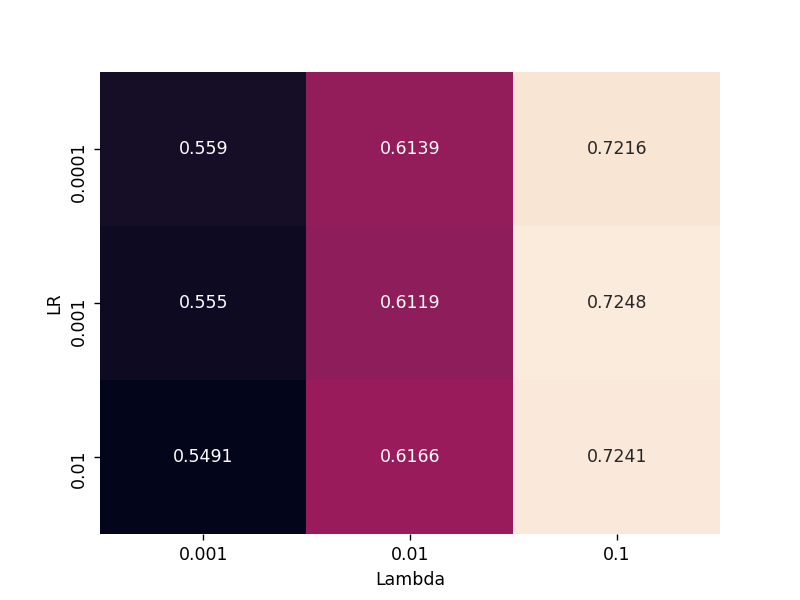

<AxesSubplot:xlabel='Lambda', ylabel='LR'>

In [39]:
fig, ax = plt.subplots()
sns.heatmap(auc_df, cbar=False, annot=True, fmt=".4g")

### 2.4 Clean up

In [ ]:
tmpdir.cleanup()

## References

<a id='references'></a>
1. Rendle, Steffen. "Factorization machines." 2010 IEEE International Conference on Data Mining. IEEE, 2010.
2. Juan, Yuchin, et al. "Field-aware factorization machines for CTR prediction." Proceedings of the 10th ACM Conference on Recommender Systems. ACM, 2016.
3. Guo, Huifeng, et al. "DeepFM: a factorization-machine based neural network for CTR prediction." arXiv preprint arXiv:1703.04247 (2017).
4. Lian, Jianxun, et al. "xdeepfm: Combining explicit and implicit feature interactions for recommender systems." Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining. ACM, 2018.
5. Qu, Yanru, et al. "Product-based neural networks for user response prediction." 2016 IEEE 16th International Conference on Data Mining (ICDM). IEEE, 2016.
6. Zhang, Weinan, Tianming Du, and Jun Wang. "Deep learning over multi-field categorical data." European conference on information retrieval. Springer, Cham, 2016.
7. He, Xiangnan, and Tat-Seng Chua. "Neural factorization machines for sparse predictive analytics." Proceedings of the 40th International ACM SIGIR conference on Research and Development in Information Retrieval. ACM, 2017.
8. Cheng, Heng-Tze, et al. "Wide & deep learning for recommender systems." Proceedings of the 1st workshop on deep learning for recommender systems. ACM, 2016.
9. Langford, John, Lihong Li, and Alex Strehl. "Vowpal wabbit online learning project." (2007).

<i>Modified by Xiaohan Zhang, based on the original version of </i>

<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>